In [1]:
!pip install metpy ######### Instalar o modulo do metpy, com rotinas meteorologicas
#### Primeiro passo, importar as bibliotecas que seraão ultilizadas
import pandas as pd  #### Leitura e processamento de dados no python, tipo o Excel do Python
import datetime as dt ########### Biblioteca com funcçoes que ajudam com datas
import numpy as np    ####### Biblioteca com funçoes Matematicas
from tqdm.notebook import trange ############ Cria barra de carregamento para poder acompanhar o processor
import matplotlib.pyplot as plt ########## Biblioteca com Funçoes para plotagem de graficos
from sklearn.preprocessing import MinMaxScaler ########## Funçoes para normalizar os dados de entrada da rede
############## TensorFlow 
from tensorflow.keras.layers import Dense,Input,Conv2D,Flatten,AveragePooling2D ########### Camadas que ultilizaremos na rede
from tensorflow.keras import Sequential ####### Tipo de modelo que usaremos
from tensorflow.keras.callbacks import ReduceLROnPlateau #### Função para Reduzir a taxa de aprendizado (LR)
import h5py
from sklearn.model_selection import train_test_split
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units

     |████████████████████████████████| 327kB 6.0MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 
     |████████████████████████████████| 194kB 12.3MB/s 


Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [8]:
!wget https://raw.githubusercontent.com/otaviomf123/Cusor-ML-para-Meteorologia-2020-04-20/master/Sondagem_Goes16.tar.xz

--2020-04-24 19:29:28--  https://raw.githubusercontent.com/otaviomf123/Cusor-ML-para-Meteorologia-2020-04-20/master/Sondagem_Goes16.tar.xz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10419252 (9.9M) [application/octet-stream]
Saving to: ‘Sondagem_Goes16.tar.xz.1’

Sondagem_Goes16.tar 100%[===================>]   9.94M  38.5MB/s    in 0.3s    

2020-04-24 19:29:30 (38.5 MB/s) - ‘Sondagem_Goes16.tar.xz.1’ saved [10419252/10419252]



In [12]:
!tar -xvf Sondagem_Goes16.tar.xz.1

Sondagem_Goes16.h5


In [0]:
######## Função de normalização Tanh, e desnormalização, para mais informação entre em :
## https://alfurka.github.io/2018-11-10-preprocessing-for-nn/ 
def tanh_norm(x,mean,std):
    return 0.5*np.tanh(0.01*((x-mean)/std))
def unorm_tanh(x,mean,std):
    return ((np.arctanh(x/0.5)/0.01)*std)+mean

In [0]:
h5file=h5py.File('Sondagem_Goes16.h5','r')
X=h5file['goes'][:]
y=h5file['sondagem'][:]
h5file.close()

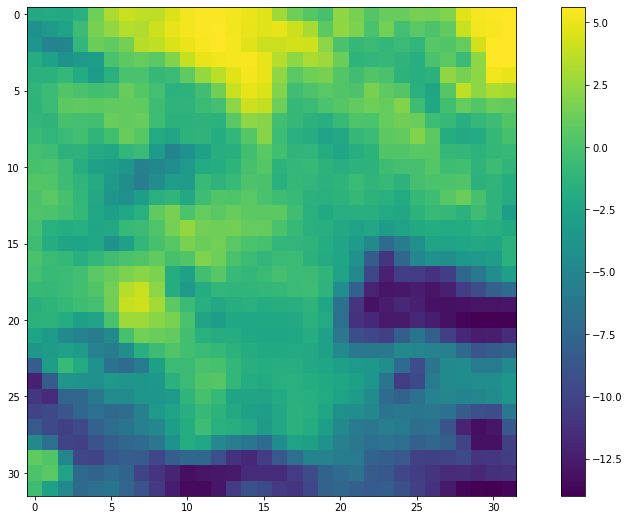

[[ 15.9   1.6]
 [  4.2  -5.6]
 [  7.9 -26.7]
 [-13.9 -59.4]
 [-48.  -58.8]
 [-59.7 -78.7]
 [-57.3 -89. ]
 [-63.6 -93.5]
 [-63.7 -93.6]
 [-63.6 -93.5]
 [-66.1 -95.3]]


In [139]:
fig=plt.figure(figsize=(16,9))
plt.imshow(X[100,:,:]-273.15)
plt.colorbar()
plt.show()
print(y[100,:])

In [141]:
### Normalizar os dados de entrada
scaler=MinMaxScaler((0,1))
print(X.shape)
sh=X.shape
x=np.reshape(X,(sh[0]*sh[1]*sh[2],1))
x=scaler.fit_transform(x)
x=np.reshape(x,(sh[0],sh[1],sh[2],1))

(10032, 32, 32)


In [0]:
### nesse processo se inicia o processo de normalização da saida (Y) da rede, iremos ultilizar a 
##função tanh_norm, no caso o perfio de temperatura
means=[]
stds=[]
y_norm=[]
for level in range(11):
    means.append(np.mean(y[:,level,0]))
    stds.append(np.std(y[:,level,0]))
for i in range(len(y)):
    xii=[]
    for level in range(11):
        xii.append(tanh_norm(y[i,level,0],means[level],stds[level]))
    y_norm.append(xii)
y_norm=np.array(y_norm)

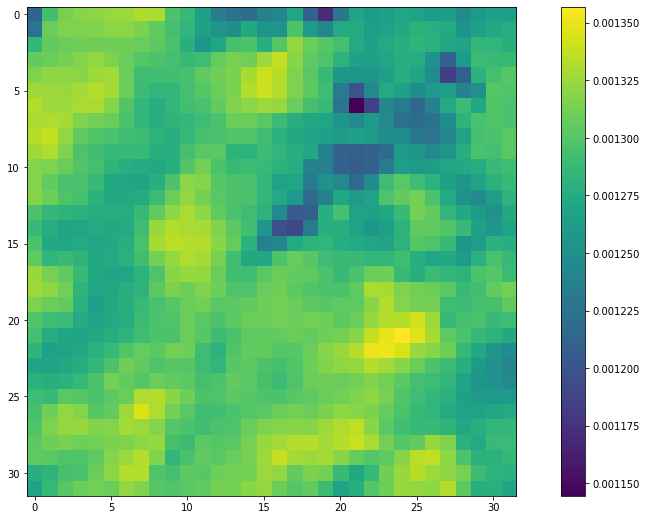

[[-99.9 -99.9]
 [  5.3  -3.1]
 [ -2.9  -3.4]
 [-14.4 -17.2]
 [-54.  -70. ]
 [-52.3 -71.4]
 [-51.3 -70.6]
 [-52.4 -72.7]
 [-55.9 -75.7]
 [-61.5 -79.1]
 [-63.6 -79.6]]
[-0.00771732 -0.00021663 -0.00152641 -0.00554028 -0.00832281 -0.00504302
 -0.0032368  -0.00120618 -0.00145016 -0.00027061  0.00017606]


In [143]:
fig=plt.figure(figsize=(16,9))
plt.imshow(x[0,:,:,0])
plt.colorbar()
plt.show()
print(y[0,:])
print(y_norm[0,:])

In [0]:
#### Dividir o conjunto de treinemento e validação
X_train, X_test, y_train, y_test = train_test_split(
    x, y_norm, test_size=0.15, random_state=875)

In [152]:
##### Modelo Tensorflow-Keras que ultilizaremos, é im modelo de apenas 1 camada pois não temos muitos dados
model=Sequential()
model.add(Input((32,32,1)))
model.add(Conv2D(16,16,activation='tanh'))
model.add(Flatten())
model.add(Dense(32,activation='tanh'))
## nesta camada abaixo a saida da rede com a função de ativação linear f(x)=x
model.add(Dense(1,activation='linear'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 17, 17, 16)        4112      
_________________________________________________________________
flatten_13 (Flatten)         (None, 4624)              0         
_________________________________________________________________
dense_26 (Dense)             (None, 32)                148000    
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 33        
Total params: 152,145
Trainable params: 152,145
Non-trainable params: 0
_________________________________________________________________


In [0]:
## huber_loss logcosh mse são outras função de minização do erro
model.compile(loss='logcosh',optimizer='Adam') ## o optimizer= Adam

In [0]:

#### A função abaixo reduz a taxa de aprendizendo mais informaçoes :
### http://deeplearningbook.com.br/a-taxa-de-aprendizado-de-uma-rede-neural/
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=200, min_lr=0.00001,verbose=1)

In [159]:
(y_test*10).max()

0.15368263322792197

In [0]:
### Aqui iremos treinar a rere com os dados ja processados 
history=model.fit(X_train,y_train[:]*10,verbose=2,epochs=3000,batch_size=16,
                  validation_data=(X_test,y_test[:]*10),callbacks=[reduce_lr])

Epoch 1/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 2/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 3/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 4/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 5/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 6/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 7/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 8/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 9/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 10/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 11/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 12/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0010
Epoch 13/3000
533/533 - 2s - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0010
Epoch 14/3000
533/533 - 2s - loss: 0.0013 - val

In [0]:
#### Plot do erro variando ao longo do treinamento 
fig=plt.figure(figsize=(12,8))
# summarize history for loss
plt.plot(history.history['loss'][10:])
plt.plot(history.history['val_loss'][10:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
pred=model.predict(x)

In [0]:
#### Iremos fazer nesse bloco a previsão do conjunto de dados teste ,ou seja a rede funcionadno no dia dia 
### e logo em seguida desnormlizaremos os dados 
pred_unorm=[]
for i in range(len(pred)):
    xii=[]
    for level in range(11):
        xii.append(unorm_tanh(pred[i,level],means[level],stds[level]))
    pred_unorm.append(xii)
pred_unorm=np.array(pred_unorm)

In [0]:
### Escolha um exemplo do conjunto de treinamento
exemplo=50
p_levels=[1000,925,850,700,500,400,300,250,200,150,100]
temp_model=np.ma.masked_where(pred_unorm[exemplo]<=-75.,pred_unorm[exemplo])
temp_obs=np.ma.masked_where(y[exemplo,:,0]==-99.9,y[exemplo,:,0])

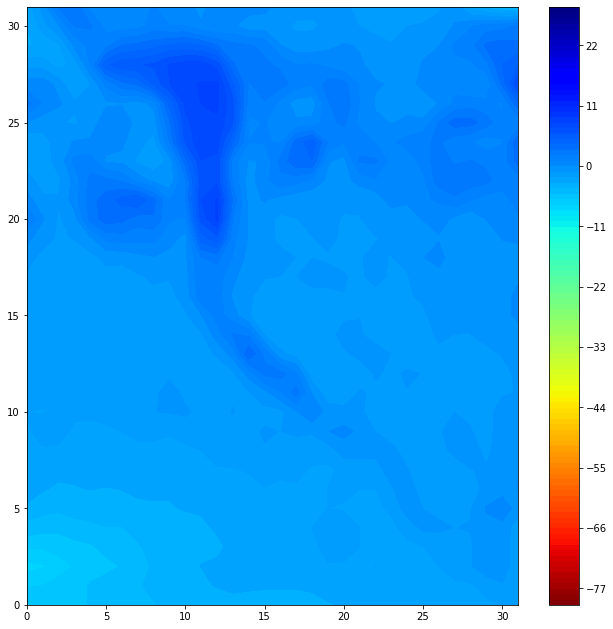

In [86]:
fig = plt.figure(figsize=(11, 11))
clev=np.arange(-80,30)
plt.contourf(X[exemplo,:,:]-273.15,clev,cmap='jet_r')
plt.colorbar()
plt.show()

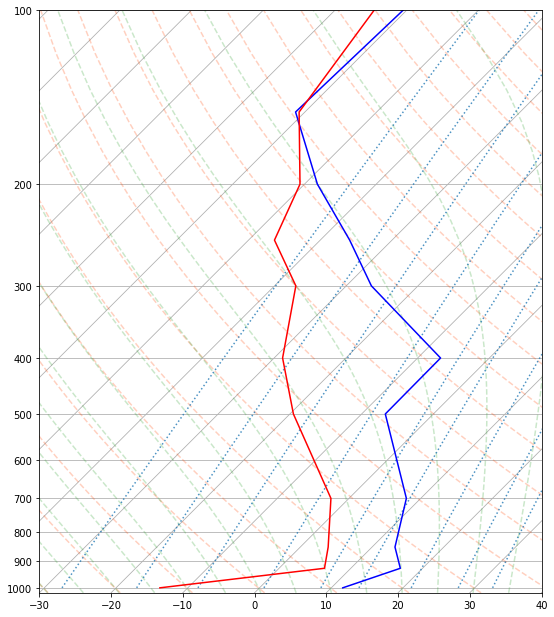

In [87]:
 fig = plt.figure(figsize=(9, 11))
# Initiate the skew-T plot type from MetPy class loaded earlier
skew = SkewT(fig, rotation=45)
skew.ax.set_xlim(-30, 40)
skew.ax.set_ylim(1020, 100)
### 
skew.plot(p_levels, temp_obs.data, 'b',)
skew.plot(p_levels, temp_model.data, 'r',)

####
# Adicionado Adiabatica seca e umida
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10) * units.K,
                       alpha=0.25, color='orangered')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5) * units.K,
                         alpha=0.25, color='tab:green')
skew.plot_mixing_lines(p=np.arange(1000, 99, -20) * units.hPa,
                       linestyle='dotted', color='tab:blue')
plt.show()

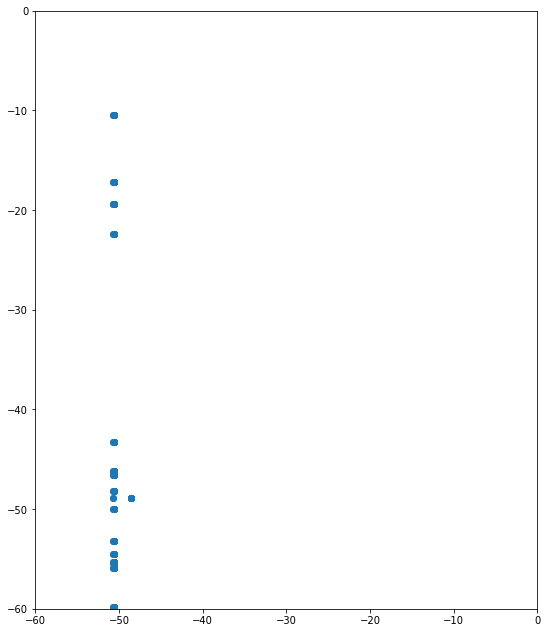

In [88]:
 fig = plt.figure(figsize=(9, 11))
plt.plot(pred_unorm[:,8],y[:,8,0],'o')
plt.xlim(-60,0)
plt.ylim(-60,0)
plt.show()

In [72]:
np.corrcoef(pred_unorm[:,8],y[:,8,0])

array([[1.        , 0.02443216],
       [0.02443216, 1.        ]])